In [487]:
import pandas as pd
import numpy as np
import math
import time
import seaborn as sns
from collections import Counter
from statistics import mean 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from minisom import MiniSom 
import random
from sklearn.linear_model import Perceptron
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

In [488]:
K_KMEANS = 5
K_KNN = 19
IN_SOM = 4

In [489]:
# Deleting unnecessary datas

def remove_duplicated(df):
    df = df.drop_duplicates()
    return df

def remove_column(dataframe, columnNames):
    return dataframe.drop(columnNames, axis=1)

def drop_all_NAN_datas(dataframe):
    return dataframe.dropna()

def replace_NAN_to_average(dataframe, columnNames):
    for columnName in columnNames:
        average = dataframe[columnName].mean(axis=0)
        dataframe[columnName] = dataframe[columnName].fillna(average)
    return dataframe

def replace_string(dataframe, columnNames, string):
    intersection = 1
    for columnName in columnNames:
        intersection = (dataframe[columnName] != string) & intersection
    return dataframe[intersection]

def delete_extreme_data(dataFrame, columnNames):
    intersection = 1
    for columnName in columnNames:
        upper=np.percentile(dataFrame[columnName],95)
        lower=np.percentile(dataFrame[columnName],5)
        intersection = dataFrame[columnName].between(lower, upper) & intersection
    return dataFrame[intersection]

def process_data(df, colName):
    def _process_date(data):
        return time.mktime(time.strptime(data, '%B %d, %Y'))
    df[colName] = list(map(_process_date, df[colName]))
    return df

In [490]:
# Convert numbers format from (k, M, G) to real number

def RegulateNumber(df, colNames):
    for colName in colNames:
        df[colName] = list(map(ConvertUnitToRealNumber, df[colName]))
    return df
        
def ConvertUnitToRealNumber(unitNumber):
    realNumber = 0
    if not isinstance(unitNumber, str):
        return unitNumber
    if unitNumber.find('k') >= 0:
        realNumber = float(unitNumber.rstrip('k'))
        realNumber *= 1000
    elif unitNumber.find('M') >= 0:
        realNumber = float(unitNumber.rstrip('M'))
        realNumber *= 1000000
    elif unitNumber.find('G') >= 0:
        realNumber = float(unitNumber.rstrip('G'))
        realNumber *= 1000000000
    elif unitNumber.find('+') >= 0:
        unitNumber = unitNumber.rstrip('+')
        realNumber = float(unitNumber.replace(',', ''))
    elif  unitNumber.find('$') >= 0:
        realNumber = float(unitNumber.replace('$', ''))
    else:
        realNumber = float(unitNumber)
    return realNumber

In [491]:
# Unity the datas unit
# Turn the datas into a convinient calculation mode

def Normalization(df, colNames):
    minMaxScaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df[colNames] = minMaxScaler.fit_transform(df[colNames])
    return df

def LabelEncoder(df, colNames):
    labelEncoder = preprocessing.LabelEncoder()
    for colName in colNames:
        df[colName] = labelEncoder.fit_transform(df[colName])
    return df

In [492]:
# dealt version and date

def process_version(df, colName):
    def _process_version(data):
        return float('0.'+data.replace('.', '')[:2])
    df[colName] = list(map(_process_version, df[colName]))
    return df

def process_date(df, colName):
    def _process_date(data):
        return time.mktime(time.strptime(data, '%d-%b-%y'))
    df[colName] = list(map(_process_date, df[colName]))
    return df

In [493]:
# Processing google play store datas
#----------------------------------------------------
# appDf_ori : app origin data
# appDf_cat : app categories
# appDf_proc : $(appDf_ori) after pre-processing
# catTables : Seperate $(appDf_proc) data by category
# payTables : Seperate $(appDf_proc) data by type

appDf_ori = pd.read_csv('googleplaystore.csv')
appDf_cat = pd.unique(appDf_ori['Category'])
appDf_proc = remove_duplicated(appDf_ori)
appDf_proc = drop_all_NAN_datas(appDf_proc)
appDf_proc = replace_string(appDf_proc,  ['Size'], 'Varies with device')
appDf_proc = replace_string(appDf_proc,  ['Installs'], 'Free')
appDf_proc = remove_column(appDf_proc, ['App', 'Android Ver', 'Current Ver', 'Genres', 'Content Rating', 'Installs'])
appDf_proc = RegulateNumber(appDf_proc, ['Reviews', 'Size', 'Price'])
appDf_proc = process_data(appDf_proc, 'Last Updated')
appDf_proc = delete_extreme_data(appDf_proc, ['Size', 'Reviews', 'Last Updated'])
appDf_proc = LabelEncoder(appDf_proc, ['Category'])
free_df = appDf_proc[appDf_proc.Type == 'Free']
free_df = remove_column(free_df, ['Type', 'Price'])
paid_df = appDf_proc[appDf_proc.Type != 'Free'].drop(columns=['Type'])

In [494]:
# catAvgRatings = free_df.groupby('Category')['Rating'].mean()
# def categoryConverter(category):
#     return catAvgRatings[category]

# free_df['Category'] = free_df['Category'].apply(categoryConverter)

In [495]:
free_df = Normalization(free_df, ['Category', 'Rating', 'Reviews', 'Size', 'Last Updated'])
paid_df = Normalization(paid_df, ['Category', 'Rating', 'Reviews', 'Size', 'Price', 'Last Updated'])

C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [496]:
rating_key = list(Counter(free_df['Rating'].sort_values()).keys())
rating_count = list(Counter(free_df['Rating'].sort_values()).values())
rating_len = sum(rating_count)
rating_percent = [rating_len / 5, 2 * rating_len / 5, 3 * rating_len / 5, 4 * rating_len / 5, rating_len]
rating_group = [-0.1]
counter = 0
for i in range(len(rating_key)-1):
    counter += rating_count[i]
    if (counter >= rating_percent[0] - 100 and len(rating_percent) > 1):
        rating_group.append(rating_key[i])
        rating_percent = rating_percent[1:]
rating_group.append(1)
def ratingConverter(rating):
    for i in range(1, 6):
        if (rating_group[i-1] < rating) and (rating <= rating_group[i]):
            return i
        
free_df['Rating'] = free_df['Rating'].apply(ratingConverter)
free_df = free_df.reset_index(drop=True)

In [497]:
print(list(map(lambda x: x * 5, rating_group))[1:])

[3.421052631578947, 3.8157894736842097, 4.078947368421052, 4.342105263157895, 5]


In [498]:
free_df.head()

,Category,Rating,Reviews,Size,Last Updated
0,0.0,2,0.000181,0.234899,0.830894
1,0.0,2,0.001134,0.167785,0.837398
2,0.0,5,0.103292,0.096644,0.998374
3,0.0,4,0.254544,0.315436,0.954472
4,0.0,3,0.001134,0.017450,0.964228


In [499]:
free_df.tail()

,Category,Rating,Reviews,Size,Last Updated
5297,0.15625,1,0.000336,0.154362,0.638211
5298,0.09375,5,0.000705,0.079195,0.369919
5299,0.34375,2,0.000001,0.014765,0.665854
5300,0.34375,4,0.000038,0.691275,0.695935
5301,0.56250,4,0.470164,0.234899,0.992683


In [598]:
free_target = free_df['Rating']
free_train, free_test, free_target_train, free_target_test = train_test_split(free_df.drop('Rating', axis=1), free_target, test_size = 0.30, random_state = 12)

In [599]:
print(free_train.head())
print(free_test.head())

      Category   Reviews      Size  Last Updated
1331   0.75000  0.047551  0.234899      0.981301
341    0.21875  0.001243  0.221477      0.993496
1432   0.87500  0.000935  0.042953      0.998374
1721   0.96875  0.022066  0.034899      0.895122
2122   0.34375  0.698109  0.234899      0.639024
      Category   Reviews      Size  Last Updated
551    0.31250  0.005066  0.038926      0.623577
499    0.28125  0.108660  0.140940      0.988618
5087   0.43750  0.990612  0.140940      0.742276
2445   0.37500  0.000015  0.302013      0.710569
4859   0.59375  0.005306  0.328859      0.992683


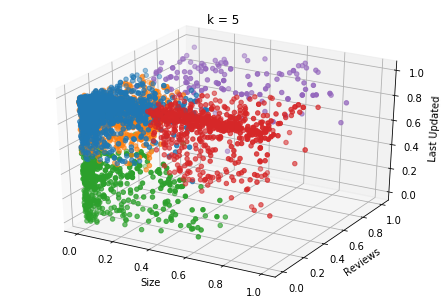

In [600]:
kmeans = KMeans(n_clusters=K_KMEANS, random_state=10).fit(free_train)
k_free_train = []
k_free_target_train = []
k_free_test_labels = kmeans.predict(free_test)
for i in range(K_KMEANS):
    i_free_train = free_train.iloc[kmeans.labels_ == i]
    i_free_target_train = free_target_train.iloc[kmeans.labels_ == i]
    k_free_train.append(i_free_train)
    k_free_target_train.append(i_free_target_train)

fig = plt.figure()
ax = Axes3D(fig)
title = 'k = ' + str(K_KMEANS)
plt.title(title)
ax.set_xlabel('Size')
ax.set_ylabel('Reviews')
ax.set_zlabel('Last Updated')
for i in range(K_KMEANS):
    ax.scatter(k_free_train[i]['Size'], k_free_train[i]['Reviews'], k_free_train[i]['Last Updated'])
#         plt.scatter(k_free_train[i]['Category'], k_free_train[i]['Reviews'])
plt.show()

In [601]:
kmeans.labels_

array([0, 1, 0, ..., 1, 0, 0])

In [602]:
kmeans.cluster_centers_

array([[0.79347373, 0.03656359, 0.14499779, 0.90372533],
       [0.2915345 , 0.02861263, 0.15448589, 0.90387291],
       [0.51713102, 0.01923921, 0.13727393, 0.35115421],
       [0.42815   , 0.06512907, 0.64525101, 0.89080846],
       [0.52026367, 0.64032032, 0.42708683, 0.94078379]])

In [603]:
k_free_test_labels

array([1, 1, 4, ..., 3, 1, 0])

In [604]:
for i in range(K_KMEANS):
    print(k_free_train[i].head())

      Category   Reviews      Size  Last Updated
1331   0.75000  0.047551  0.234899      0.981301
1432   0.87500  0.000935  0.042953      0.998374
1721   0.96875  0.022066  0.034899      0.895122
2433   0.87500  0.180188  0.208054      1.000000
1630   0.78125  0.000243  0.114094      0.919512
      Category   Reviews      Size  Last Updated
341    0.21875  0.001243  0.221477      0.993496
3788   0.34375  0.000518  0.369128      0.652033
822    0.53125  0.002258  0.088591      0.981301
602    0.37500  0.000836  0.028188      0.656911
4130   0.34375  0.000007  0.114094      0.891870
      Category   Reviews      Size  Last Updated
2906   0.46875  0.000046  0.154362      0.439024
2897   0.93750  0.000017  0.181208      0.405691
3777   0.34375  0.000917  0.315436      0.374797
3188   0.37500  0.000079  0.167785      0.468293
2575   0.34375  0.016690  0.059060      0.360976
      Category   Reviews      Size  Last Updated
2902   0.62500  0.000013  0.476510      0.987805
2798   0.46875  0.00

[[   0.    0. 3237.]
 [  23.   54.    0.]
 [   0.  397.    0.]]
[(0, 2), (1, 0), (1, 1), (2, 1)]


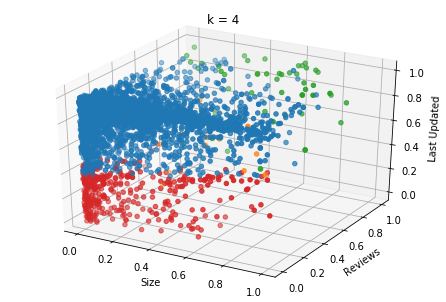

In [659]:
import minisom

som = MiniSom(3, 3, IN_SOM, sigma=0.1, learning_rate=0.2)
som.train_random(free_train.values, 200)
result = som.activation_response(free_train.values)
print(result)

m_cluster_uni = []
for i in range(3):
    for j in range(3):
        if result[i][j] != 0:
            m_cluster_uni.append((i, j))
print(m_cluster_uni)

s_cluster = []
m_free_train_label = []
for idx, row in free_train.iterrows():
    s_cluster.append(som.winner(list(row)))
for cluster in s_cluster:
    m_free_train_label.append(m_cluster_uni.index(cluster))
m_free_train_label = np.array(m_free_train_label)

m_free_train = []
m_free_target_train = []
for i in range(len(m_cluster_uni)):
    i_free_train = free_train.iloc[m_free_train_label == i]
    i_free_target_train = free_target_train.iloc[m_free_train_label == i]
    m_free_train.append(i_free_train)
    m_free_target_train.append(i_free_target_train)
    
s_cluster = []
m_free_test_label = []
for idx, row in free_test.iterrows():
    s_cluster.append(som.winner(list(row)))
for cluster in s_cluster:
    m_free_test_label.append(m_cluster_uni.index(cluster))
m_free_test_label = np.array(m_free_test_label)

fig = plt.figure()
ax = Axes3D(fig)
title = 'k = ' + str(len(np.unique(result))-1)
plt.title(title)
ax.set_xlabel('Size')
ax.set_ylabel('Reviews')
ax.set_zlabel('Last Updated')
for i in range(len(np.unique(result))-1):
    ax.scatter(m_free_train[i]['Size'], m_free_train[i]['Reviews'], m_free_train[i]['Last Updated'])
#         plt.scatter(k_free_train[i]['Category'], k_free_train[i]['Reviews'])
plt.show()

In [544]:
for i in range(len(m_cluster_uni)):
    print(m_free_train[i].head())

      Category   Reviews      Size  Last Updated
2574   0.62500  0.003027  0.030872      0.634146
1314   0.81250  0.130341  0.342282      0.962602
4398   0.37500  0.007260  0.068456      0.633333
1082   0.34375  0.001876  0.167785      0.975610
1064   0.34375  0.078681  0.275168      0.852033
      Category   Reviews      Size  Last Updated
2310   0.46875  0.002219  0.081879      0.371545
1356   0.75000  0.065420  0.068456      0.300000
3234   0.34375  0.000602  0.261745      0.520325
2190   0.90625  0.000918  0.543624      0.452846
3012   0.75000  0.315612  0.005369      0.090244
      Category   Reviews      Size  Last Updated
2567    0.4375  0.248256  0.597315      0.015447
      Category   Reviews      Size  Last Updated
3510   0.34375  0.000009  0.037584      0.833333
3283   0.18750  0.000032  0.016107      0.740650
186    0.12500  0.001242  0.288591      0.971545
173    0.12500  0.006424  0.140940      0.992683
353    0.21875  0.000214  0.234899      0.993496
      Category   Rev

In [513]:
def accuracy(test_y, target_y):
    correctNum = 0
    for test, target in zip(test_y, target_y):
        if test == target:
            correctNum += 1
    return correctNum / len(test_y) * 100

In [514]:
def accuracies(length, test_y, target_y, test_labels):
    accuracy_list = []
    for i in range(length):
        accuracy_list.append(accuracy(test_y[i], target_y[test_labels == i]))
        print('cluster', i, 'accuracy:', accuracy_list[-1], '%')
    print('total accuracy:', sum(accuracy_list) / len(accuracy_list), '%')

In [515]:
def plotResult(regr_predict, actualRating):
    for i in range(0, len(actualRating), 50):
        plt.xlabel('Datas')
        plt.ylabel('Rating')
        if i+50 <= len(actualRating):
            dy = actualRating[i:i+50] - regr_predict[i:i+50]
            plt.errorbar(range(50), actualRating[i:i+50], yerr=dy, ecolor='orange', fmt='o')
        else:
            dy = actualRating[i:len(actualRating)] - regr_predict[i:len(actualRating)]
            plt.errorbar(range(len(actualRating) - i), actualRating[i:len(actualRating)], yerr=dy, ecolor='orange', fmt='o')
        plt.legend()
        plt.show()

In [516]:
def plotResults(regr_predicts, actualRatings, labels):
    for i in range(len(regr_predicts)):
        print('cluster', i)
        plotResult(regr_predicts[i], actualRatings[labels == i])

No handles with labels found to put in legend.


k =  19 accuracy 26.021370207416716 %


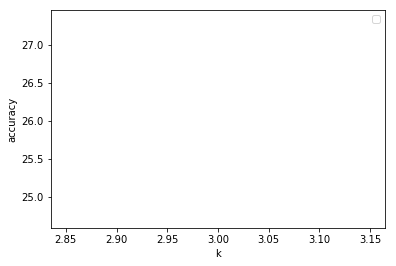

In [675]:
from sklearn.neighbors import KNeighborsClassifier

knn_accuracy = []
for k in range(K_KNN, K_KNN+1, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(free_train, free_target_train)
    knn_predict = knn.predict(free_test)
    knn_accuracy.append(accuracy(knn_predict, free_target_test))
    print('k = ', k, 'accuracy', accuracy(knn_predict, free_target_test), '%')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(range(3, 4, 2), knn_accuracy)
plt.legend()
plt.show()
# plotResult(knn_predict, free_target_test)

In [676]:
k_knn = [KNeighborsClassifier(n_neighbors=K_KNN) for i in range(K_KMEANS)]
k_knn_predict = []
for i in range(K_KMEANS):
    k_knn[i].fit(k_free_train[i], k_free_target_train[i])
    k_knn_predict.append(k_knn[i].predict(free_test[k_free_test_labels == i]))
accuracies(K_KMEANS, k_knn_predict, free_target_test, k_free_test_labels)
# plotResults(k_knn_predict, free_target_test, k_free_test_labels)

cluster 0 accuracy: 26.61290322580645 %
cluster 1 accuracy: 24.675324675324674 %
cluster 2 accuracy: 28.636363636363637 %
cluster 3 accuracy: 26.523297491039425 %
cluster 4 accuracy: 33.33333333333333 %
total accuracy: 27.956244472373506 %


In [677]:
m_knn = [KNeighborsClassifier(n_neighbors=K_KNN) for i in range(len(m_cluster_uni))]
m_knn_predict = []
for i in range(len(m_cluster_uni)):
    m_knn[i].fit(m_free_train[i], m_free_target_train[i])
    if (len(free_test[m_free_test_label == i]) != 0):
        m_knn_predict.append(m_knn[i].predict(free_test[m_free_test_label == i]))
accuracies(len(m_cluster_uni), m_knn_predict, free_target_test, m_free_test_label)
# plotResults(m_knn_predict, free_target_test, m_free_test_label)

cluster 0 accuracy: 25.342960288808662 %
cluster 1 accuracy: 25.0 %
cluster 2 accuracy: 39.39393939393939 %
cluster 3 accuracy: 26.70807453416149 %
total accuracy: 29.111243554227386 %


In [669]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', random_state=10, hidden_layer_sizes=(46,))
mlp.fit(free_train, free_target_train)
mlp_predict = mlp.predict(free_test)
print('accuracy', accuracy(mlp_predict, free_target_test), '%')

accuracy 27.40414833438089 %


In [670]:
k_mlp = [MLPClassifier(solver='lbfgs', random_state=10, hidden_layer_sizes=(46,)) for i in range(K_KMEANS)]
k_mlp_predict = []
for i in range(K_KMEANS):
    k_mlp[i].fit(k_free_train[i], k_free_target_train[i])
    k_mlp_predict.append(k_mlp[i].predict(free_test[k_free_test_labels == i]))
accuracies(K_KMEANS, k_mlp_predict, free_target_test, k_free_test_labels)
# plotResults(k_mlp_predict, free_target_test, k_free_test_labels)

cluster 0 accuracy: 28.830645161290324 %
cluster 1 accuracy: 23.747680890538035 %
cluster 2 accuracy: 32.72727272727273 %
cluster 3 accuracy: 26.16487455197133 %
cluster 4 accuracy: 36.84210526315789 %
total accuracy: 29.66251571884606 %


In [671]:
m_mlp = [MLPClassifier(solver='lbfgs', random_state=10, hidden_layer_sizes=(46,)) for i in range(len(m_cluster_uni))]
m_mlp_predict = []
for i in range(len(m_cluster_uni)):
    m_mlp[i].fit(m_free_train[i], m_free_target_train[i])
    m_mlp_predict.append(m_mlp[i].predict(free_test[m_free_test_label == i]))
accuracies(len(m_cluster_uni), m_mlp_predict, free_target_test, m_free_test_label)
# plotResults(m_mlp_predict, free_target_test, m_free_test_label)

cluster 0 accuracy: 25.63176895306859 %
cluster 1 accuracy: 33.33333333333333 %
cluster 2 accuracy: 42.42424242424242 %
cluster 3 accuracy: 31.05590062111801 %
total accuracy: 33.11131133294059 %


In [672]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=28, random_state=12)
rfc = rfc.fit(free_train, free_target_train)
rfc_predict = rfc.predict(free_test)
rfc_accuracy.append(accuracy(rfc_predict, free_target_test))
print(d, 'accuracy', accuracy(rfc_predict, free_target_test), '%')
# plotResult(rfc_predict, free_target_test)

49 accuracy 29.85543683218102 %


C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [673]:
k_rfc = [RandomForestClassifier(max_depth=28, random_state=12) for i in range(K_KMEANS)]
k_rfc_predict = []
for i in range(K_KMEANS):
    k_rfc[i].fit(k_free_train[i], k_free_target_train[i])
    k_rfc_predict.append(k_rfc[i].predict(free_test[k_free_test_labels == i]))
accuracies(K_KMEANS, k_rfc_predict, free_target_test, k_free_test_labels)
# plotResults(k_rfc_predict, free_target_test, k_free_test_labels)

cluster 0 accuracy: 31.048387096774192 %
cluster 1 accuracy: 28.7569573283859 %
cluster 2 accuracy: 25.454545454545453 %
cluster 3 accuracy: 26.881720430107524 %
cluster 4 accuracy: 47.368421052631575 %
total accuracy: 31.902006272488926 %


C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

In [674]:
m_rfc = [RandomForestClassifier(max_depth=28, random_state=12) for i in range(len(m_cluster_uni))]
m_rfc_predict = []
for i in range(len(m_cluster_uni)):
    m_rfc[i].fit(m_free_train[i], m_free_target_train[i])
    m_rfc_predict.append(m_rfc[i].predict(free_test[m_free_test_label == i]))
accuracies(len(m_cluster_uni), m_rfc_predict, free_target_test, m_free_test_label)
# plotResults(m_rfc_predict, free_target_test, m_free_test_label)

cluster 0 accuracy: 30.541516245487365 %
cluster 1 accuracy: 16.666666666666664 %
cluster 2 accuracy: 51.515151515151516 %
cluster 3 accuracy: 30.434782608695656 %
total accuracy: 32.289529259000304 %


C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Freddy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
